In [1]:
import pandas as pd

In [2]:
from pyldl.algorithms import LDL_DA

In [3]:
from pyldl.metrics import score, euclidean
from pyldl.utils import LDLEarlyStopping

In [4]:
from pyldl.applications import facial_emotion_recognition as fer

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
import keras

In [7]:
sX, sy = fer.load_bu_3dfe('demo/BU-3DFE/', size=(128, 128))

In [8]:
tX, ty = fer.load_jaffe('demo/jaffe/', size=(128, 128))

In [9]:
sy = LDL_DA.reorder_y(sy, LDL_DA.ORDER_SBU_3DFE)

In [10]:
tX_temp, tX_test, ty_temp, ty_test = train_test_split(tX, ty, train_size=int(ty.shape[1]*12.5), random_state=0)
tX_train, tX_val, ty_train, ty_val = train_test_split(tX_temp, ty_temp, test_size=.2, random_state=0)

In [11]:
model = LDL_DA()

In [12]:
enc_inputs = keras.Input(shape=sX.shape[1:])
encodes = keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))(enc_inputs)
pooling = keras.layers.GlobalAveragePooling2D()(encodes)
encoder = keras.Model(inputs=enc_inputs, outputs=pooling)

In [13]:
dec_inputs = keras.Input(shape=(pooling.shape[1],))
outputs = keras.layers.Dense(sy.shape[1], activation='softmax')(dec_inputs)
decoder = keras.Model(inputs=dec_inputs, outputs=outputs)

In [14]:
model.fit(sX, sy, tX_train, ty_train, batch_size=128, model={'encoder': encoder, 'decoder': decoder},
          margin=1., optimizer=keras.optimizers.Adam(1e-4), ft_optimizer=keras.optimizers.Adam(1e-5), verbose=1,
          X_val=tX_val, y_val=ty_val, callbacks=[LDLEarlyStopping(monitor='kl_divergence', patience=50)]);

 185/1000 ━━━━━━━━━━━━━━━━━━━━ 3435s 19s/step - loss: 0.0441 - kl_divergence: 0.0441  
Epoch 185: early stopping (best kl_divergence: 0.02331416713714187).
  51/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 334ms/step - loss: 0.0236 - kl_divergence: 0.0236 
Epoch 51: early stopping (best kl_divergence: 0.023314021265462344).


In [15]:
metrics=["chebyshev", "clark", "canberra", "kl_divergence", "cosine", "intersection"]

In [16]:
y_pred = model.predict(tX_test)
print(pd.Series(score(ty_test, y_pred, metrics=metrics), index=metrics))

chebyshev        0.074715
clark            0.270391
canberra         0.574720
kl_divergence    0.030099
cosine           0.970733
intersection     0.901475
dtype: float64


In [17]:
df = pd.DataFrame({'score': euclidean(ty_test, y_pred, reduction=None),
                   'group': ty_test.argmax(axis=1)})
samples = df.groupby('group')['score'].idxmin().values

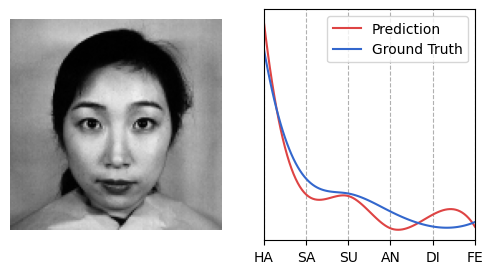

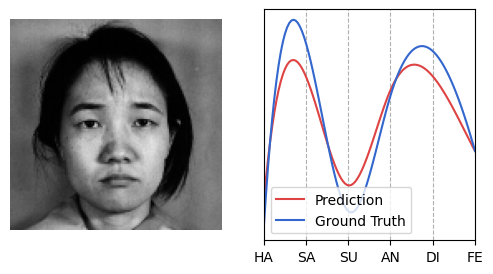

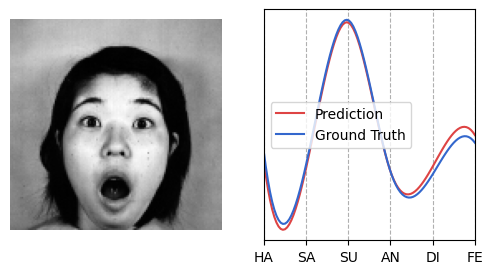

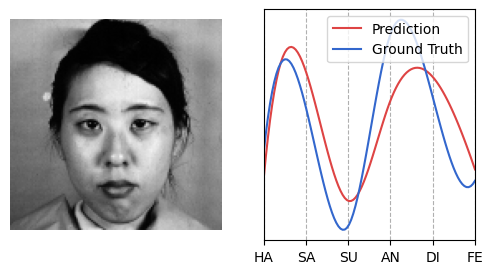

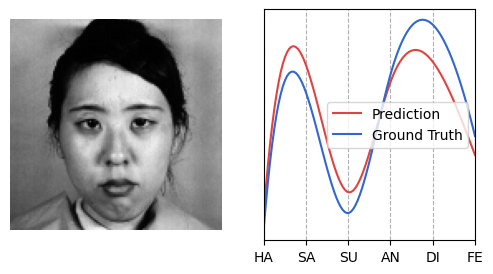

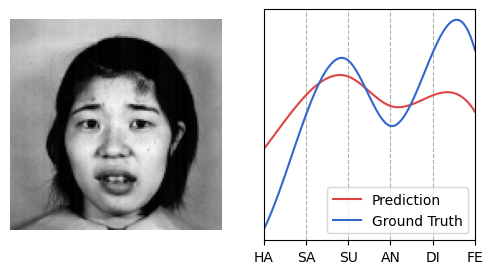

In [18]:
for i in samples:
    fer.visualization(tX_test[i], y_pred[i], ty_test[i])